In [1]:
# import libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import ReLU
import keras_tuner as kt
import numpy as np

from ipynb.fs.full.models import (make_vgg16, make_nn, kt_model_build, 
    trimmed_kt_model_build, cat_kt_model_build, extra_trimmed_kt_model_build)
import pandas as pd
from sklearn import preprocessing
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report


### Import and Merge Data

In [16]:
col_labels = ['og_idx', 'tpop', 'bpop', 'wpop', 'area', 'label', 'image_file']
color = 'green'

if color is not None:
    dem_train_df_egs = pd.read_csv(f'Outputs/{color}_train_data_egs_label.csv', names=col_labels, header=0)
    dem_test_df_egs = pd.read_csv(f'Outputs/{color}_test_data_egs_label.csv', names=col_labels, header=0)
    dem_val_df_egs = pd.read_csv(f'Outputs/{color}_val_data_egs_label.csv', names=col_labels, header=0)

    dem_train_df_comp = pd.read_csv(f'Outputs/{color}_train_data_label.csv', names=col_labels, header=0)
    dem_test_df_comp = pd.read_csv(f'Outputs/{color}_test_data_label.csv', names=col_labels, header=0)
    dem_val_df_comp = pd.read_csv(f'Outputs/{color}_val_data_label.csv', names=col_labels, header=0)

    prepross_train = pd.read_csv(f'Outputs/{color}_processed_train_df.csv').drop(['Unnamed: 0'], axis=1)
    prepross_test = pd.read_csv(f'Outputs/{color}_processed_test_df.csv').drop(['Unnamed: 0'], axis=1)
    prepross_val = pd.read_csv(f'Outputs/{color}_processed_val_df.csv').drop(['Unnamed: 0'], axis=1)

else:
    dem_train_df_egs = pd.read_csv('Outputs/train_data_egs_label.csv', names=col_labels, header=0)
    dem_test_df_egs = pd.read_csv('Outputs/test_data_egs_label.csv', names=col_labels, header=0)
    dem_val_df_egs = pd.read_csv('Outputs/val_data_egs_label.csv', names=col_labels, header=0)

    dem_train_df_comp = pd.read_csv('Outputs/train_data_label.csv', names=col_labels, header=0)
    dem_test_df_comp = pd.read_csv('Outputs/test_data_label.csv', names=col_labels, header=0)
    dem_val_df_comp = pd.read_csv('Outputs/val_data_label.csv', names=col_labels, header=0)

    prepross_train = pd.read_csv('Outputs/processed_train_df.csv').drop(['Unnamed: 0'], axis=1)
    prepross_test = pd.read_csv('Outputs/processed_test_df.csv').drop(['Unnamed: 0'], axis=1)
    prepross_val = pd.read_csv('Outputs/processed_val_df.csv').drop(['Unnamed: 0'], axis=1)

dem_train_df_egs = dem_train_df_egs.merge(prepross_train, how='inner', on='image_file')
dem_test_df_egs = dem_test_df_egs.merge(prepross_test, how='inner', on='image_file')
dem_val_df_egs = dem_val_df_egs.merge(prepross_val, how='inner', on='image_file')

dem_train_df_comp = dem_train_df_comp.merge(prepross_train, how='inner', on='image_file')
dem_test_df_comp = dem_test_df_comp.merge(prepross_test, how='inner', on='image_file')
dem_val_df_comp = dem_val_df_comp.merge(prepross_val, how='inner', on='image_file')

df_cat = pd.read_csv(f'Outputs/categories_{color}.csv').drop(['Unnamed: 0'], axis=1)

dem_train_df_egs = dem_train_df_egs.merge(df_cat, how='inner', on='image_file')
dem_test_df_egs = dem_test_df_egs.merge(df_cat, how='inner', on='image_file')
dem_val_df_egs = dem_val_df_egs.merge(df_cat, how='inner', on='image_file')

df_list = [dem_train_df_egs, dem_test_df_egs, dem_val_df_egs, dem_train_df_comp, dem_test_df_comp, dem_val_df_comp]

In [17]:
dem_train_df_egs

,og_idx,tpop,bpop,wpop,area,label,image_file,process_image
0,4921,708585,34089,674496,1.449730,False,plot274d17.png,_1220_3560968.png
1,8501,695322,334409,360913,0.014349,False,plot473d15.png,_2601_2833792.png
2,1758,700623,128809,571814,0.089332,True,plot98d18.png,_6458_534301.png
3,8817,700303,39435,660868,0.428190,False,plot490d13.png,_2714_9568743.png
4,1143,713032,353656,359376,0.011783,True,plot64d8.png,_6206_3393055.png
...,...,...,...,...,...,...,...,...
6475,1160,698711,22248,676463,0.474896,True,plot65d11.png,_6207_9061433.png
6476,5770,703386,39814,663572,0.318272,True,plot321d4.png,_1558_7752262.png
6477,673,714418,33387,681031,0.305488,False,plot38d17.png,_2037_712503.png
6478,8781,700303,39435,660868,0.428190,False,plot488d13.png,_2694_453648.png


In [18]:
dem_train_df_comp

,og_idx,tpop,bpop,wpop,area,label,image_file,process_image
0,4921,708585,34089,674496,1.449730,False,plot274d17.png,_1220_3560968.png
1,8501,695322,334409,360913,0.014349,False,plot473d15.png,_2601_2833792.png
2,1758,700623,128809,571814,0.089332,True,plot98d18.png,_6458_534301.png
3,8817,700303,39435,660868,0.428190,False,plot490d13.png,_2714_9568743.png
4,1143,713032,353656,359376,0.011783,True,plot64d8.png,_6206_3393055.png
...,...,...,...,...,...,...,...,...
6475,1160,698711,22248,676463,0.474896,True,plot65d11.png,_6207_9061433.png
6476,5770,703386,39814,663572,0.318272,False,plot321d4.png,_1558_7752262.png
6477,673,714418,33387,681031,0.305488,False,plot38d17.png,_2037_712503.png
6478,8781,700303,39435,660868,0.428190,False,plot488d13.png,_2694_453648.png


### Helper Functions

In [6]:
def normalize(df, cols):
    """
    Min-max normalizes provided columns within dataframe.

    Paramters: 
        df: pd.Dataframe - dataframe with columns to normalize
        cols: list - list of column names as strings to normalize

    return: 
        None - Normalizes the provided columns in df in place
    """
    x = df[cols].values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df[cols] = x_scaled

In [7]:
def img_array(df_image_col, subset, color=None, resize=False):
    """
    Converts images to np.array format for use in Keras models.

    Paramters: 
        df_image_col: pd.Dataframe column, list - column in dataframe with image file names as strings
        subset: str - subset that the data belongs to. One of three options: 'train', 'test', 'val'
        color: str - color of districts that corresponds to the save directory with the images. E.g., 'blue', 'red'. Default=None
        resize: Boolean - whether the images have been preprocessed/resized. Default=False

    return: 
        ret_arr: np.array - numerical representation of images in single array
    """
    # initialize return array
    ret_arr = []

    # loop through image file names
    for i in df_image_col:

        # read and append image to return array
        if resize:
            
            if color is not None:
                im = cv2.imread('Outputs/images/'+ color + '/' + subset + '/' + 'processed/' + i)
            
            else:
                im = cv2.imread('Outputs/images/'+ subset + '/' + 'processed/' + i)
        else:
            im = cv2.imread('Outputs/images/'+ subset + '/' + i)
            
        ret_arr.append(im)

    return np.array(ret_arr, dtype=object)

In [8]:
def gen_report(fit_model, test_data, test_labels, title, le=None, multiclass=False):
    """
    Generates confusion matrix and classification report for given model on provided test data.

    Paramters: 
        fit_model: Keras.model - compiled Keras model
        test_data: np.array, pd.Dataframe column, list - X input for test data
        test_labels: np.array, pd.Dataframe column, list - y input for test data (labels)
        title: str - title of confusion matrix
        le: preprocessing.LabelEncoder - label encoder to encode multiclass labels to numerical values [0,1,2]. Default=None
        multiclass: Boolean - whether the model is predicting a binary (False) or multiclass (True) output label. Default=False

    return: 
        None - generates the confusion matrix that can then be saved and prints the classification report 
    """
    # make model predictions on test data
    preds = fit_model.predict(test_data)

    # generate confusion matrix comparing predictions to actual labels
    if multiclass:

        # reverse label encoding so confusion matrix displays actual labels not integers
        pred_labels = le.inverse_transform([np.argmax(x) for x in preds])
        test_labels = le.inverse_transform(test_labels)

        conf = confusion_matrix(test_labels, pred_labels, labels=['low', 'medium', 'high'])
        disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=['low', 'medium', 'high'])
    
    else:

        # get Boolean label from continuous prediction confidence score
        pred_labels = [False if x < 0.5 else True for x in preds]
        
        conf = confusion_matrix(test_labels, pred_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    
    # display confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

    # print classification report
    print(classification_report(test_labels, pred_labels))

### Final Data Preparation

In [19]:
# normalize demographic features
cols = ['tpop', 'bpop', 'wpop', 'area']

for df in df_list:
    normalize(df, cols)

In [20]:
dem_train_df_egs.head()

,og_idx,tpop,bpop,wpop,area,label,image_file,process_image
0,4921,0.637196,0.060505,0.921169,0.383303,False,plot274d17.png,_1220_3560968.png
1,8501,0.166643,0.786097,0.182638,0.000684,False,plot473d15.png,_2601_2833792.png
2,1758,0.354715,0.289355,0.679339,0.020672,True,plot98d18.png,_6458_534301.png
3,8817,0.343362,0.073422,0.889073,0.110999,False,plot490d13.png,_2714_9568743.png
4,1143,0.794969,0.832598,0.179019,0.000000,True,plot64d8.png,_6206_3393055.png


In [21]:
# create image arrays for both compactness labeled data and EGS labeled data

# compactness label df
train_images_comp = img_array(dem_train_df_comp['process_image'], 'train', color=color,resize=True)
test_images_comp = img_array(dem_test_df_comp['process_image'], 'test', color=color,resize=True)
val_images_comp = img_array(dem_val_df_comp['process_image'], 'val', color=color,resize=True)

# egs label df
train_images_pross = img_array(dem_train_df_egs['process_image'], 'train', color=color, resize=True)
test_images_pross = img_array(dem_test_df_egs['process_image'], 'test', color=color, resize=True)
val_images_pross = img_array(dem_val_df_egs['process_image'], 'val', color=color, resize=True)

In [ ]:
# encode multiclass labels to numerical values
le = preprocessing.LabelEncoder()

le.fit(dem_train_df_egs['category'].values)
y_train = le.transform(dem_train_df_egs['category'].values)

le.fit(dem_val_df_egs['category'].values)
y_val = le.transform(dem_val_df_egs['category'].values)

le.fit(dem_test_df_egs['category'].values)
y_test = le.transform(dem_test_df_egs['category'].values)

### Create Models

In [12]:
# make individual CNN and NN models with functions from models.ipynb
cnn = make_vgg16(dropout=0.2)
nn = make_nn(4)

# combine the model outputs
combined_model = tf.keras.layers.concatenate([nn.output, cnn.output],axis=1)

# final output layers
x = Dense(4, activation='relu')(combined_model)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[nn.input, cnn.input], outputs=x)

In [11]:
# multiclass model
x2 = Dense(4, activation='relu')(combined_model)
x2 = Dense(3, activation='softmax')(x2)

cat_model = Model(inputs=[nn.input, cnn.input], outputs=x2)

### Compile Models

In [13]:
opt = Adam(learning_rate=1e-3, epsilon=1e-3 / 200) 
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
cat_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Fit, Train, and Test Models

In [32]:
# create early stopping callback
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=3, verbose=1, mode='auto')

##### EGS-Labeled Model

In [23]:
# egs label model - preprocessed images
pre_egs_model = model.fit(
	x=[dem_train_df_egs.iloc[:,1:-3].values.astype(np.float32), train_images_pross.astype(np.float32)], 
	y=dem_train_df_egs['label'].values,
	validation_data=([dem_val_df_egs.iloc[:,1:-3].values.astype(np.float32), val_images_pross.astype(np.float32)], dem_val_df_egs['label'].values),
	callbacks=early,
	epochs=20,
	batch_size=32)

Epoch 1/20
203/203 [==============================] - 460s 2s/step - loss: 0.6852 - accuracy: 0.6275 - val_loss: 0.6691 - val_accuracy: 0.6764
Epoch 2/20
203/203 [==============================] - 446s 2s/step - loss: 0.6661 - accuracy: 0.6514 - val_loss: 0.6531 - val_accuracy: 0.6764
Epoch 3/20
203/203 [==============================] - 456s 2s/step - loss: 0.6564 - accuracy: 0.6514 - val_loss: 0.6435 - val_accuracy: 0.6764
Epoch 4/20
203/203 [==============================] - 451s 2s/step - loss: 0.6512 - accuracy: 0.6514 - val_loss: 0.6379 - val_accuracy: 0.6764
Epoch 00004: early stopping


In [46]:
# evaluate model
eval_results = model.evaluate(x=[dem_test_df_egs.iloc[:,1:-3].values.astype(np.float32), test_images_pross.astype(np.float32)],
y=dem_test_df_egs['label'].values)

eval_results

85/85 [==============================] - 166s 2s/step - loss: 0.3728 - accuracy: 0.8556


[0.37280595302581787, 0.855555534362793]

##### Multiclass Model

In [16]:
# cateogorical model - low, med, high
cat_pre_egs_model = cat_model.fit(
	x=[dem_train_df_egs.iloc[:,1:-4].values.astype(np.float32), train_images_pross.astype(np.float32)], 
	y=y_train,
	validation_data=([dem_val_df_egs.iloc[:,1:-4].values.astype(np.float32), val_images_pross.astype(np.float32)], y_val),
	callbacks=early,
	epochs=20,
	batch_size=32)

Epoch 1/20
203/203 [==============================] - 439s 2s/step - loss: 1.0742 - accuracy: 0.4923 - val_loss: 1.0286 - val_accuracy: 0.5111
Epoch 2/20
203/203 [==============================] - 438s 2s/step - loss: 0.9712 - accuracy: 0.5551 - val_loss: 0.9200 - val_accuracy: 0.6236
Epoch 3/20
203/203 [==============================] - 443s 2s/step - loss: 0.8623 - accuracy: 0.6515 - val_loss: 0.8440 - val_accuracy: 0.6583
Epoch 4/20
203/203 [==============================] - 437s 2s/step - loss: 0.8153 - accuracy: 0.6892 - val_loss: 0.8179 - val_accuracy: 0.6861
Epoch 5/20
203/203 [==============================] - 434s 2s/step - loss: 0.7779 - accuracy: 0.7023 - val_loss: 0.7904 - val_accuracy: 0.6889
Epoch 6/20
203/203 [==============================] - 432s 2s/step - loss: 0.7619 - accuracy: 0.7031 - val_loss: 0.7801 - val_accuracy: 0.7028
Epoch 7/20
203/203 [==============================] - 436s 2s/step - loss: 0.7526 - accuracy: 0.7060 - val_loss: 0.7712 - val_accuracy: 0.7028

In [17]:
# evaluate model
eval_results = cat_model.evaluate(x=[dem_test_df_egs.iloc[:,1:-4].values.astype(np.float32), test_images_pross.astype(np.float32)],
y=y_test)

eval_results

57/57 [==============================] - 108s 2s/step - loss: 0.7444 - accuracy: 0.7083


[0.7444256544113159, 0.7083333134651184]

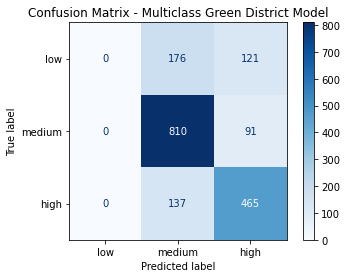

              precision    recall  f1-score   support

        high       0.69      0.77      0.73       602
         low       0.00      0.00      0.00       297
      medium       0.72      0.90      0.80       901

    accuracy                           0.71      1800
   macro avg       0.47      0.56      0.51      1800
weighted avg       0.59      0.71      0.64      1800



c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Afris\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
gen_report(cat_model, 
[dem_test_df_egs.iloc[:,1:-4].values.astype(np.float32), test_images_pross.astype(np.float32)],
y_test,
'Confusion Matrix - Multiclass Green District Model',
le=le,
multiclass=True
)

##### Compactness-Labeled Model

In [13]:
# compactness label model
comp_model = model.fit(
	x=[dem_train_df_comp.iloc[:,1:-3].values.astype(np.float32), train_images_comp.astype(np.float32)], 
	y=dem_train_df_comp['label'].values,
	validation_data=([dem_val_df_comp.iloc[:,1:-3].values.astype(np.float32), val_images_comp.astype(np.float32)], dem_val_df_comp['label'].values),
	callbacks=early,
	epochs=20,
	batch_size=32)

Epoch 1/20
203/203 [==============================] - 434s 2s/step - loss: 0.7180 - accuracy: 0.5062 - val_loss: 0.6945 - val_accuracy: 0.5278
Epoch 2/20
203/203 [==============================] - 422s 2s/step - loss: 0.6947 - accuracy: 0.4940 - val_loss: 0.6942 - val_accuracy: 0.5083
Epoch 3/20
203/203 [==============================] - 442s 2s/step - loss: 0.6939 - accuracy: 0.4907 - val_loss: 0.6940 - val_accuracy: 0.4917
Epoch 4/20
203/203 [==============================] - 459s 2s/step - loss: 0.6933 - accuracy: 0.4991 - val_loss: 0.6934 - val_accuracy: 0.5069
Epoch 00004: early stopping


In [14]:
# evaluate model
eval_results = model.evaluate(x=[dem_test_df_comp.iloc[:,1:-3].values.astype(np.float32), test_images_comp.astype(np.float32)],
y=dem_test_df_comp['label'].values)

eval_results

57/57 [==============================] - 113s 2s/step - loss: 0.6931 - accuracy: 0.5089


[0.6930582523345947, 0.5088889002799988]

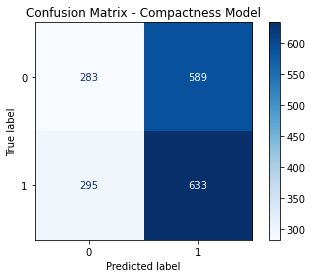

              precision    recall  f1-score   support

       False       0.49      0.32      0.39       872
        True       0.52      0.68      0.59       928

    accuracy                           0.51      1800
   macro avg       0.50      0.50      0.49      1800
weighted avg       0.50      0.51      0.49      1800



In [16]:
gen_report(model, 
[dem_test_df_comp.iloc[:,1:-3].values.astype(np.float32), test_images_comp.astype(np.float32)],
dem_test_df_comp['label'].values,
'Confusion Matrix - Compactness Model'
)

### Parameter Search with Keras Tuner

In [28]:
tname = 'hyperband_test_green'
rseed = 42

# initialize hyperband tuner
tuner = kt.Hyperband(trimmed_kt_model_build, objective='val_accuracy',
                    max_epochs=10, project_name=tname, seed=rseed
)

# Bayesian
# tuner = kt.BayesianOptimization(trimmed_kt_model_build, objective='val_accuracy',
# max_trials=10, 
# seed= rseed,
# project_name=tname
# )

INFO:tensorflow:Reloading Oracle from existing project .\hyperband_test_green\oracle.json
INFO:tensorflow:Reloading Tuner from .\hyperband_test_green\tuner0.json


In [29]:
# search parameters 
tuner.search(x=[dem_train_df_egs.iloc[:,1:-3].values.astype(np.float32), train_images_pross.astype(np.float32)], 
	y=dem_train_df_egs['label'].values,
	validation_data=([dem_val_df_egs.iloc[:,1:-3].values.astype(np.float32), val_images_pross.astype(np.float32)], dem_val_df_egs['label'].values),
    epochs=10,
    batch_size=32,
    callbacks=[early]
    )


Trial 17 Complete [00h 44m 18s]
val_accuracy: 0.8333333134651184

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 01h 44m 28s

Search: Running Trial #18

Value             |Best Value So Far |Hyperparameter
relu              |relu              |input_activation
5                 |4                 |num_layers
selu              |gelu              |activation_0
12                |21                |nodes_0
relu              |gelu              |activation_1
12                |30                |nodes_1
gelu              |selu              |activation_2
30                |24                |nodes_2
0.25              |0.3               |droprate
3                 |4                 |cnn_set1_num_layers
relu              |relu              |cnn_set1_activation_0
3500              |3500              |cnn_set1_nodes_0
selu              |relu              |cnn_set1_activation_1
1500              |2500              |cnn_set1_nodes_1
selu              |relu              |cnn_set1

KeyboardInterrupt: 

In [30]:
# check best parameter values
best_params = tuner.get_best_hyperparameters()[0]
best_params.values

{'input_activation': 'relu',
 'num_layers': 4,
 'activation_0': 'gelu',
 'nodes_0': 21,
 'activation_1': 'gelu',
 'nodes_1': 30,
 'activation_2': 'selu',
 'nodes_2': 24,
 'droprate': 0.30000000000000004,
 'cnn_set1_num_layers': 4,
 'cnn_set1_activation_0': 'relu',
 'cnn_set1_nodes_0': 3500,
 'cnn_set1_activation_1': 'relu',
 'cnn_set1_nodes_1': 2500,
 'cnn_set1_activation_2': 'relu',
 'cnn_set1_nodes_2': 2000,
 'learning_rate': 0.006209939317006995,
 'epsilon': 1.5711053576416204e-06,
 'cnn_set1_activation_3': 'selu',
 'cnn_set1_nodes_3': 1000,
 'activation_3': 'relu',
 'nodes_3': 9,
 'cnn_set1_activation_4': 'gelu',
 'cnn_set1_nodes_4': 3000,
 'activation_4': 'relu',
 'nodes_4': 6,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0014'}

In [31]:
# get model with best parameters
best_model = tuner.get_best_models(1)[0]

In [33]:
# fit that model to training data
ktuner_egs_model = best_model.fit(
	x=[dem_train_df_egs.iloc[:,1:-3].values.astype(np.float32), train_images_pross.astype(np.float32)], 
	y=dem_train_df_egs['label'].values,
	validation_data=([dem_val_df_egs.iloc[:,1:-3].values.astype(np.float32), val_images_pross.astype(np.float32)], dem_val_df_egs['label'].values),
	callbacks=early,
	epochs=20,
	batch_size=32)

Epoch 1/20
203/203 [==============================] - 446s 2s/step - loss: 0.4079 - accuracy: 0.8221 - val_loss: 0.4216 - val_accuracy: 0.8292
Epoch 2/20
203/203 [==============================] - 442s 2s/step - loss: 0.4027 - accuracy: 0.8228 - val_loss: 0.3852 - val_accuracy: 0.8306
Epoch 3/20
203/203 [==============================] - 441s 2s/step - loss: 0.3976 - accuracy: 0.8239 - val_loss: 0.3808 - val_accuracy: 0.8292
Epoch 4/20
203/203 [==============================] - 435s 2s/step - loss: 0.3942 - accuracy: 0.8248 - val_loss: 0.3826 - val_accuracy: 0.8111
Epoch 5/20
203/203 [==============================] - 439s 2s/step - loss: 0.3892 - accuracy: 0.8293 - val_loss: 0.3728 - val_accuracy: 0.8333
Epoch 6/20
203/203 [==============================] - 436s 2s/step - loss: 0.3859 - accuracy: 0.8304 - val_loss: 0.3713 - val_accuracy: 0.8194
Epoch 7/20
203/203 [==============================] - 434s 2s/step - loss: 0.3865 - accuracy: 0.8289 - val_loss: 0.3685 - val_accuracy: 0.8278

In [35]:
# test KT model on test data
tuner_eval_results = best_model.evaluate(x=[dem_test_df_egs.iloc[:,1:-3].values.astype(np.float32), test_images_pross.astype(np.float32)],
y=dem_test_df_egs['label'].values
# y=y_test
)

tuner_eval_results

57/57 [==============================] - 110s 2s/step - loss: 0.3898 - accuracy: 0.8161


[0.3898319602012634, 0.8161110877990723]

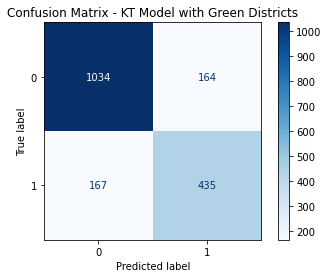

              precision    recall  f1-score   support

       False       0.86      0.86      0.86      1198
        True       0.73      0.72      0.72       602

    accuracy                           0.82      1800
   macro avg       0.79      0.79      0.79      1800
weighted avg       0.82      0.82      0.82      1800



In [36]:
gen_report(best_model, 
[dem_test_df_egs.iloc[:,1:-3].values.astype(np.float32), test_images_pross.astype(np.float32)],
dem_test_df_egs['label'].values,
'Confusion Matrix - KT Model with Green Districts'
)

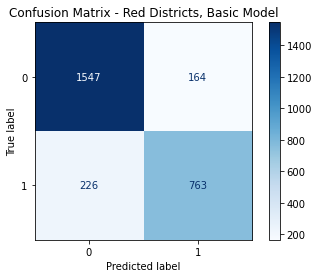

              precision    recall  f1-score   support

       False       0.87      0.90      0.89      1711
        True       0.82      0.77      0.80       989

    accuracy                           0.86      2700
   macro avg       0.85      0.84      0.84      2700
weighted avg       0.85      0.86      0.85      2700



In [47]:
gen_report(model, 
[dem_test_df_egs.iloc[:,1:-3].values.astype(np.float32), test_images_pross.astype(np.float32)],
dem_test_df_egs['label'].values,
'Confusion Matrix - Red Districts, Basic Model'
)